In [2]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# 读取数据

In [3]:

sigmod0_npy_dir = train_dir + r'\\sigmod0\\npy\\'
aari_npy_dir = train_dir + r'\\mask\\aari\\npy\\'
aari_normail_npy_dir = train_dir + r'\\mask\\aari\\npy\\normail_npy\\'
osisaf_npy_dir = train_dir + r'\\mask\\osisaf\\npy\\'


In [4]:
sigmod0_npy_files = glob.glob(sigmod0_npy_dir + '*.npy')
aari_npy_files = glob.glob(aari_npy_dir + r'*.npy')
osisaf_npy_files = glob.glob(osisaf_npy_dir + r'*.npy')

osi_array = np.load(osisaf_npy_files[0])
aari_array = np.load(aari_npy_files[0])

new_osi_array = np.full(shape=osi_array.shape[:2], fill_value=0)
new_aari_array = np.full(shape=osi_array.shape[:2], fill_value=0)


look = np.full(shape=osi_array.shape[:2], fill_value=0)

for i in range(3):
    new_osi_array += osi_array[:,:,i]
    
for i in range(3):
    new_aari_array += aari_array[:,:,i]
    

In [255]:
new_osi_array = np.full(shape=osi_array.shape[:2], fill_value=0)
new_aari_array = np.full(shape=osi_array.shape[:2], fill_value=0)


look = np.full(shape=osi_array.shape[:2], fill_value=0)

In [256]:
for i in range(3):
    new_osi_array += osi_array[:,:,i]
    
for i in range(3):
    new_aari_array += aari_array[:,:,i]
    

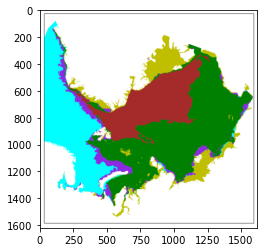

In [268]:
plt.imshow(np.load(aari_npy_files[0]))

In [312]:

for aari_npy_file, sigmod0_npy_file in zip(aari_npy_files, sigmod0_npy_files):
    aari_array = np.load(aari_npy_file)
    sigmod0_array = np.load(sigmod0_npy_file)
    new_aari_array = np.full(shape=aari_array.shape[:2], fill_value=0)
    for i in range(3):
        new_aari_array += aari_array[:,:,i]
    new_aari_array[new_aari_array == 765] = 1
    new_aari_array[new_aari_array == 128] = 2
    new_aari_array[new_aari_array == 510] = 3
    new_aari_array[new_aari_array == 249] = 4
    new_aari_array[new_aari_array == 382] = 5
    new_aari_array[new_aari_array == 407] = 6
    
    np.save(aari_npy_dir + r'\\normail_npy\\' + sigmod0_npy_file.split('\\')[-1],new_aari_array)
    
        

large_num_index = np.argsort(plt.hist(new_aari_array.flatten(),bins=765)[0])[-10:]
plt.hist(new_aari_array.flatten(),bins=765)[1][large_num_index]

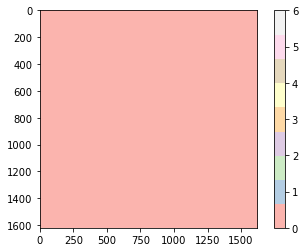

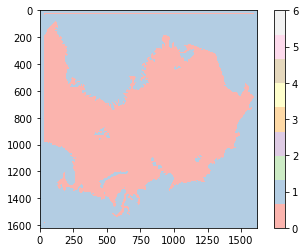

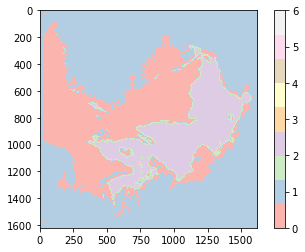

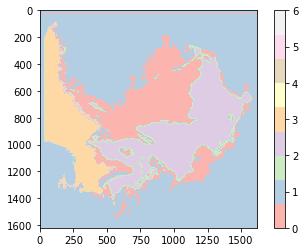

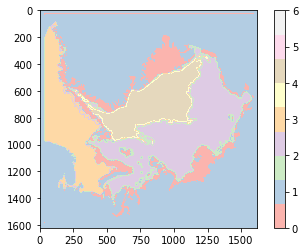

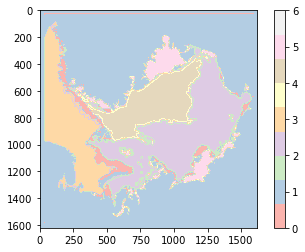

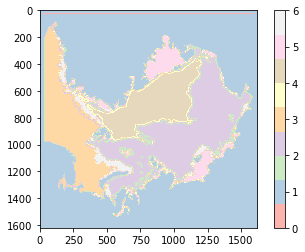

In [257]:
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

 
look[new_aari_array == 765] = 1 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 128] = 2 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 510] = 3 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 249] = 4 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 382] = 5
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 407] = 6
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()


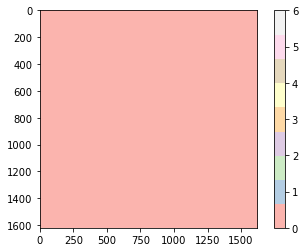

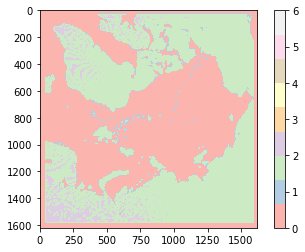

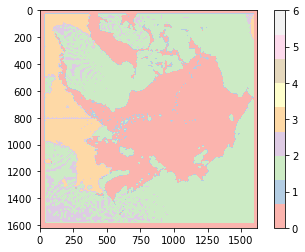

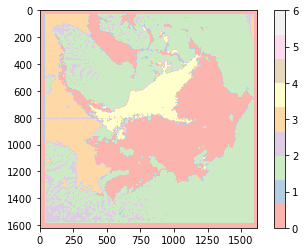

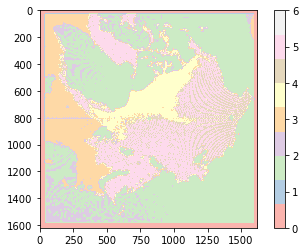

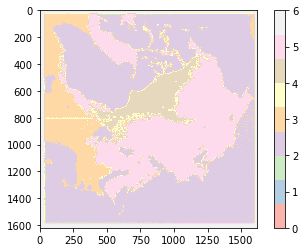

In [218]:
look[new_osi_array == 0] = 1 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 128] = 2 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 384] = 3 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 403] = 4 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 502] = 5
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 765] = 6
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()


In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (1620, 1620))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (1620, 1620))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
TRAIN_LENGTH = image_count
BATCH_SIZE = 2
BUFFER_SIZE = 2
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

NameError: name 'image_count' is not defined

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(load_and_preprocess_image(display_list[i]))
        plt.axis('off')
    plt.show()

InvalidArgumentError: Expected image (JPEG, PNG, or GIF), got unknown format starting with '\223NUMPY\001\000v\000{\'desc' [Op:DecodeJpeg]

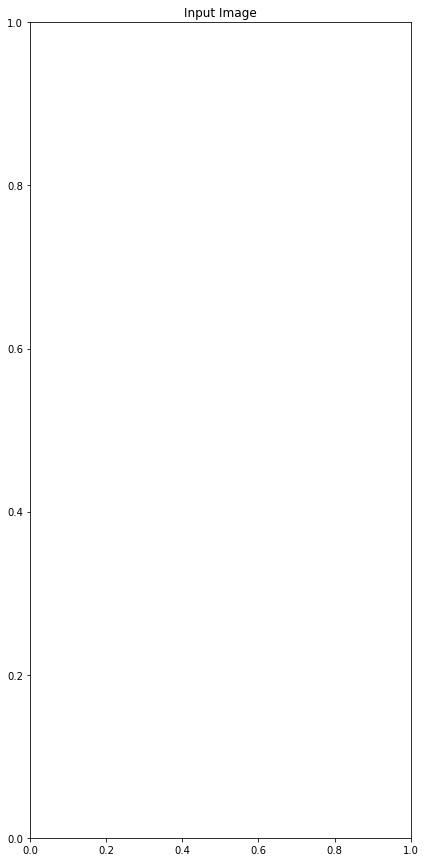

In [12]:
sample_image, sample_mask = training_path[0]
display([sample_image, sample_mask])

In [12]:
OUTPUT_CHANNELS = 3

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[1620, 1620, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

# START

In [1]:
from IPython.display import clear_output
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from skimage import exposure
from matplotlib.patches import Polygon
from RSData import *
from HaiYangData import *
from tensorflow_examples.models.pix2pix import pix2pix

import matplotlib.patches as mpatches
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import cv2
import io
import shapefile
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
train_dir = r'E:\python_workfile\sea_ice_classification\training4'

aari_npy_dir = glob.glob(train_dir + r'\mask\npy\small_size\*.npy')

sigmod0_img_dir = train_dir + r'\\sigmod0\\small_size\\'
aari_img_dir = train_dir + r'\\mask\\small_size\\'
# aari_img_dir = train_dir + r'\\mask\\npy\\test\\'

# sigmod0_img_dir = train_dir + r'\\sigmod0\\'
# aari_img_dir = train_dir + r'\\mask\\'

sigmod0_img_files = glob.glob(sigmod0_img_dir + '*.png')
aari_img_files = glob.glob(aari_img_dir + '*.png')


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import random
import glob


image_paths = sigmod0_img_files
mask_paths = aari_img_files
training_path = [[image,mask]for image,mask in zip(image_paths,mask_paths)]
random.shuffle(training_path)
image_count = len(training_path)
path_slice = int(2*(image_count/3))

In [5]:
train_path = training_path[:path_slice]
test_path = training_path[path_slice:]

In [6]:
def getBinaryTensor(imgTensor, boundary = 220): 
    one = tf.ones_like(imgTensor) 
    zero = tf.zeros_like(imgTensor) 
    return tf.where(imgTensor > boundary, one, zero)

In [7]:
len(train_path)

3114

In [8]:
def preprocess_mask(mask):
    mask_arr = np.array(mask)
    
#     mask_arr[mask_arr == 254] = 0
#     mask_arr[mask_arr == 75] = 1
#     mask_arr[mask_arr == 178] = 2
#     mask_arr[mask_arr == 78] = 3
#     mask_arr[mask_arr == 169] = 4
#     mask_arr[mask_arr == 92] = 5
#     mask_arr[mask_arr == 0] = 6
#     mask_arr[mask_arr >6] = 0
    
    return mask_arr

In [9]:
def split_train_paths(paths):
    train_img_paths = [path[0] for path in paths]
    train_mask_paths = [path[1] for path in paths]
    return train_img_paths, train_mask_paths

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [128, 128])
#   image = tf.image.resize(image, [1565, 1565])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_mask(path):
    mask = tf.io.read_file(path)
#     mask = np.array(mask)
    mask = tf.image.decode_jpeg(mask, channels=1)
    
    mask = tf.image.resize(mask, [128, 128])
#     mask_arr = np.array(mask)
#     mask -= 220.0
#     mask /= 10
#     mask_arr[mask_arr == 254] = 0
#     mask_arr[mask_arr == 75] = 1
#     mask_arr[mask_arr == 178] = 2
#     mask_arr[mask_arr == 78] = 3
#     mask_arr[mask_arr == 169] = 4
#     mask_arr[mask_arr == 92] = 5
#     mask_arr[mask_arr == 0] = 6
#     mask_arr[mask_arr >6] = 0

#     index = tf.where(mask == 254)
#     mask[index].assgin(0)
    
    return mask
#     return mask



In [10]:
train_image_paths, train_mask_paths = split_train_paths(train_path)
test_image_paths, test_mask_paths = split_train_paths(test_path)


In [11]:
train_img_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
train_mask_path_ds = tf.data.Dataset.from_tensor_slices(train_mask_paths)

test_img_path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_mask_path_ds = tf.data.Dataset.from_tensor_slices(test_mask_paths)

In [12]:
train_image_ds = train_img_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_mask_ds = train_mask_path_ds.map(load_and_preprocess_mask, num_parallel_calls=AUTOTUNE)

test_image_ds = test_img_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_mask_ds = test_mask_path_ds.map(load_and_preprocess_mask, num_parallel_calls=AUTOTUNE)

In [13]:
train = tf.data.Dataset.zip((train_image_ds,train_mask_ds))
test = tf.data.Dataset.zip((test_image_ds,test_mask_ds))

In [14]:
TRAIN_LENGTH = image_count
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [15]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i],loc='center')
        if i==0:
            display_list[i] = (display_list[i] * 20 / 255) - 25
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),vmin=-25,vmax=-5,cmap = plt.cm.jet)
            plt.colorbar(fraction=0.05, pad=0.05)
            plt.axis('off')
            
        else:
            plt.imshow(display_list[i],vmin=0,vmax=5,cmap = plt.cm.jet)
#             plt.colorbar(fraction=0.05, pad=0.05)
            color = ['blue','dodgerblue', 'aquamarine', 'greenyellow', 'orangered','brown']
            labels = ['no data', 'first year ice', 'old ice', 'fast ice','young ice','nilas']
                    #用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
            patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 
            plt.legend(loc = 'best',handles=patches, bbox_to_anchor=(0.95,1.12), ncol=4)
            plt.axis('off')
    plt.show()

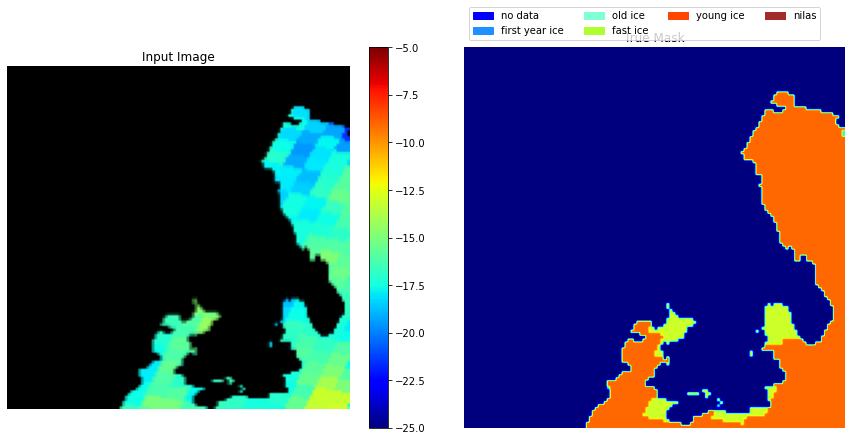

In [17]:
for image, mask in train.take(18):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [18]:
OUTPUT_CHANNELS = 6

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128 , 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [20]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128 , 3])
    x = inputs

    # 在模型中降频取样
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # 升频取样然后建立跳跃连接
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # 这是模型的最后一层
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# 模型保存
'''checkpoint = tf.train.Checkpoint(myModel = model,myOptimizer=model.optimizer)
manager = tf.train.CheckpointManager(checkpoint, directory=train_dir + '\\model_checkpoint',
                                    checkpoint_name='model.ckpt', max_to_keep = 200)'''

"checkpoint = tf.train.Checkpoint(myModel = model,myOptimizer=model.optimizer)\nmanager = tf.train.CheckpointManager(checkpoint, directory=train_dir + '\\model_checkpoint',\n                                    checkpoint_name='model.ckpt', max_to_keep = 200)"

In [24]:
#恢复参数
model_to_be_restored = model
checkpoint = tf.train.Checkpoint(myModel = model_to_be_restored)
checkpoint.restore(train_dir + '\\model_checkpoint\\model.ckpt-1')

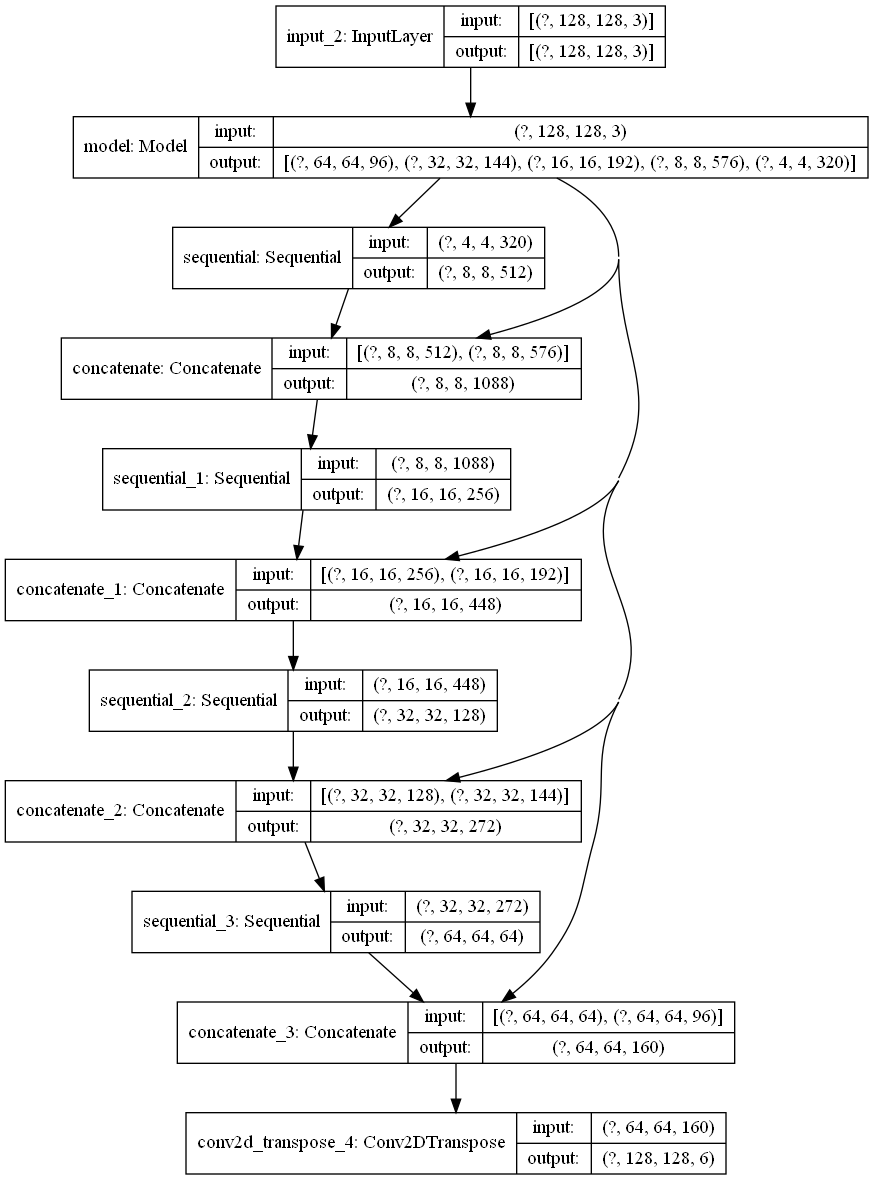

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [28]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [31]:
config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
 
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [32]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [33]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TRAIN_LENGTH//BATCH_SIZE//VAL_SUBSPLITS



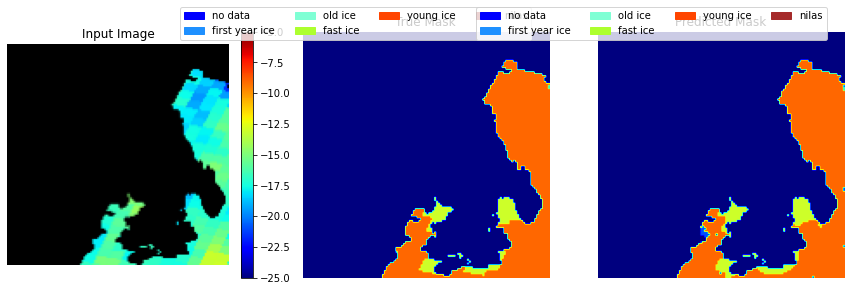


Sample Prediction after epoch 50

145/145 [==============================] - 11s 73ms/step - loss: 0.0242 - accuracy: 0.9907 - val_loss: 0.1975 - val_accuracy: 0.9529


In [34]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [35]:
 checkpoint.save(train_dir + '\\model_checkpoint\\model.ckpt')

'E:\\python_workfile\\sea_ice_classification\\training4\\model_checkpoint\\model.ckpt-2'

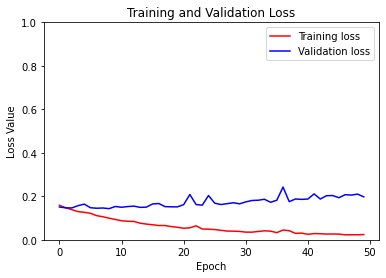

In [36]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)
# epochs = range(1300)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

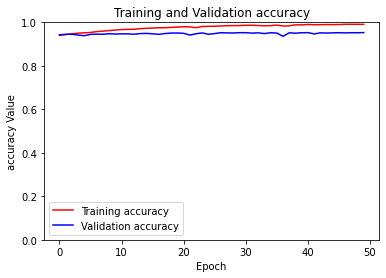

In [37]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

# epochs = range(EPOCHS)
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

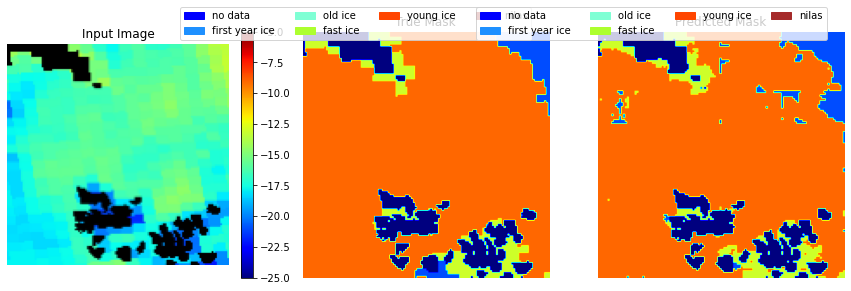

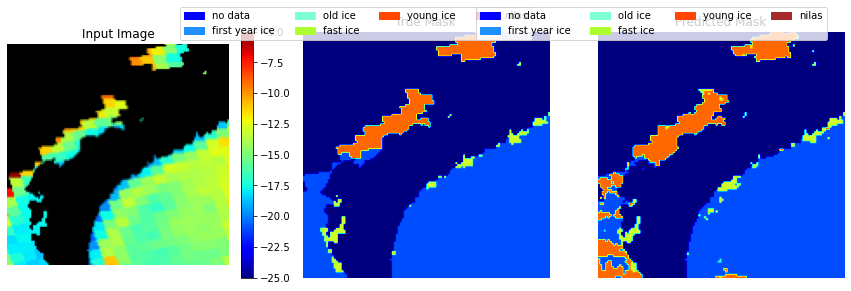

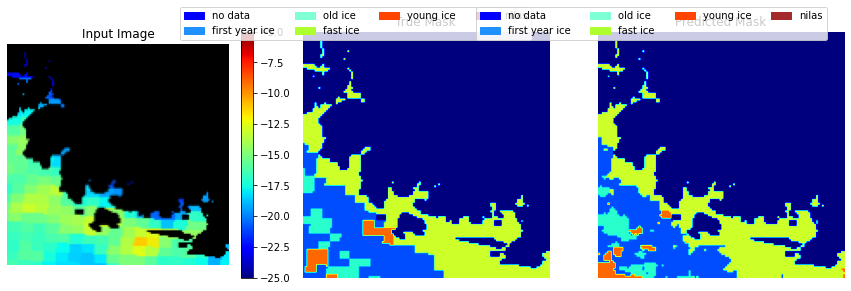

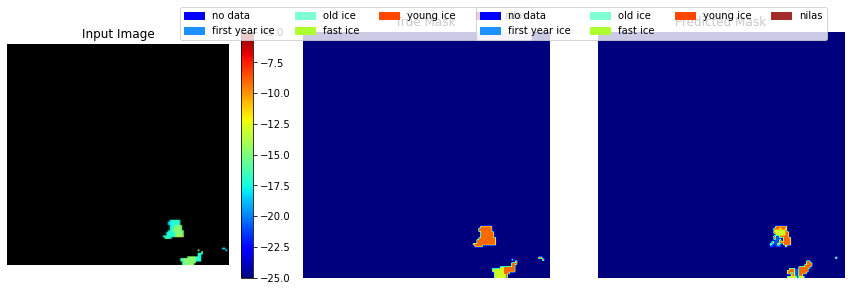

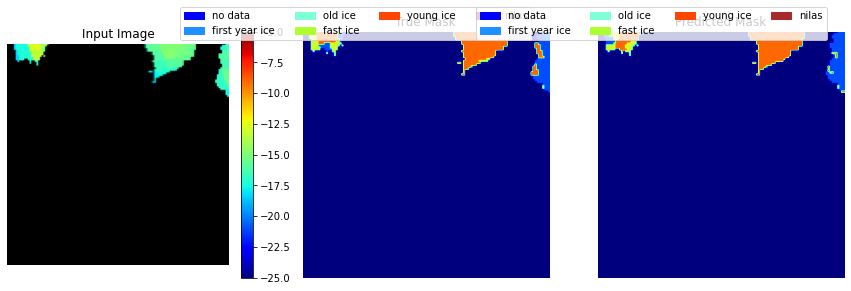

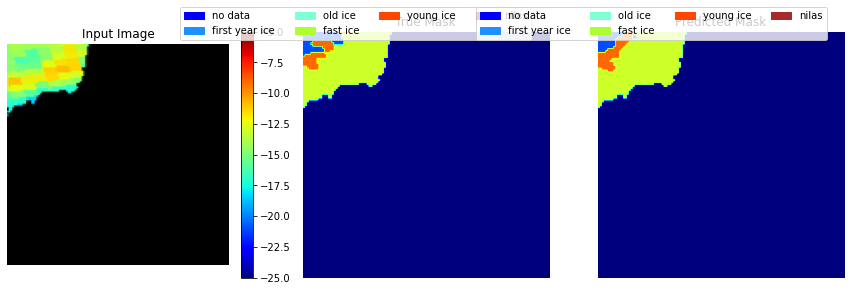

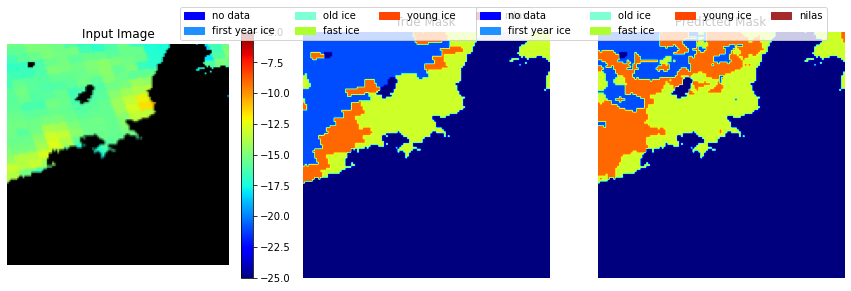

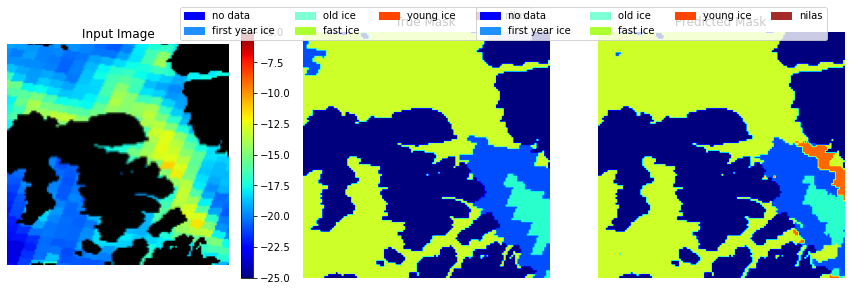

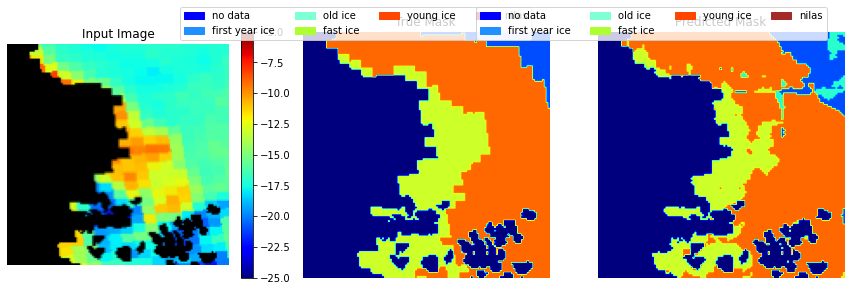

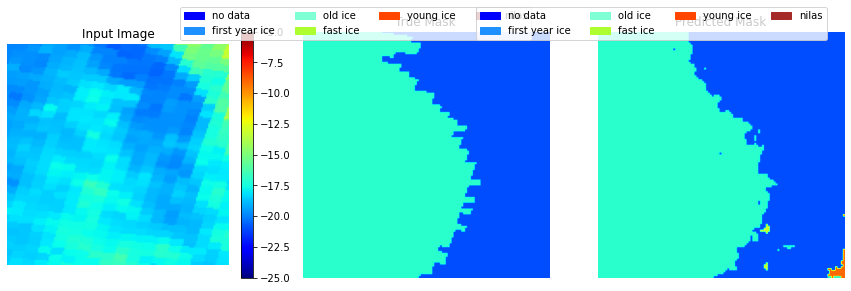

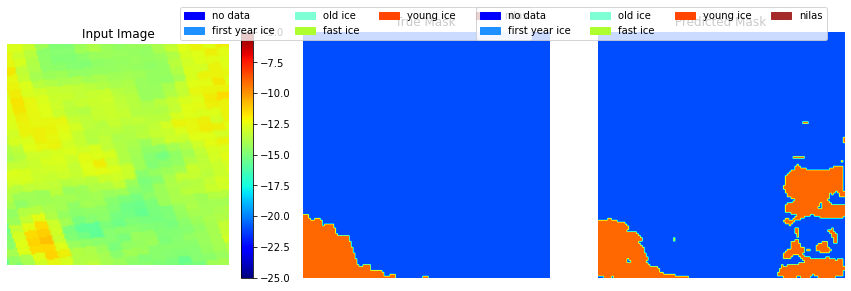

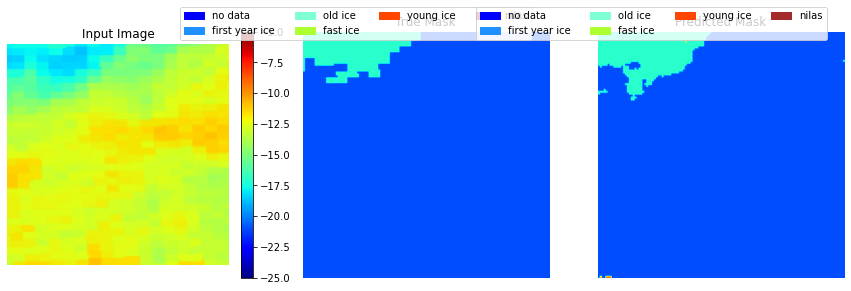

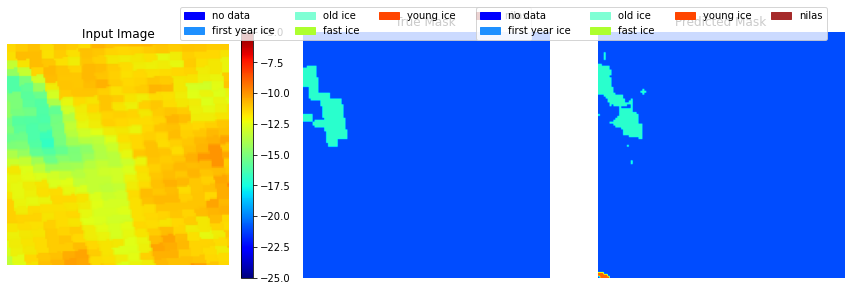

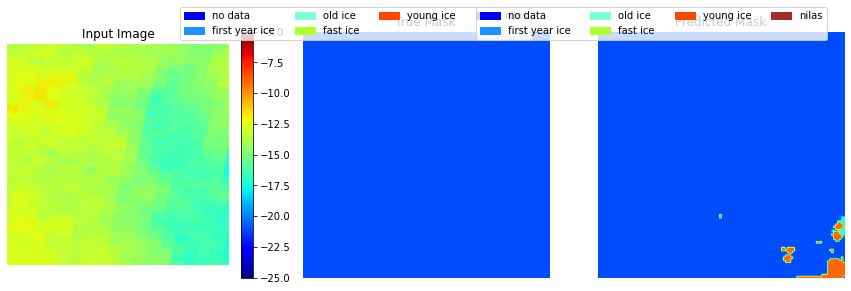

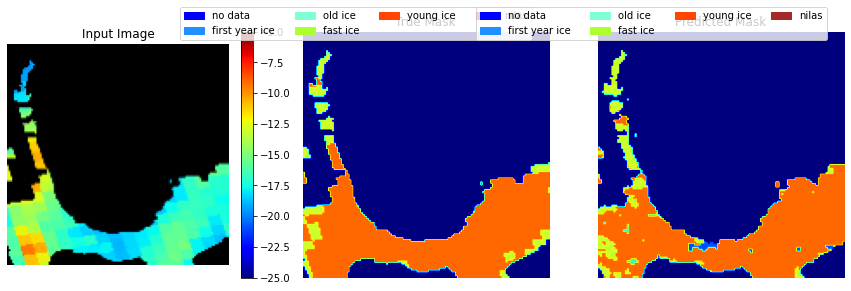

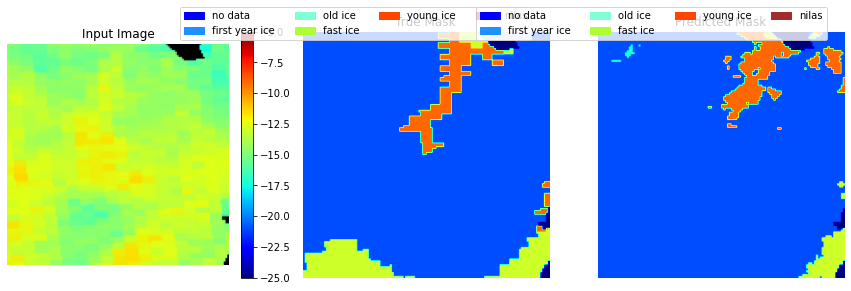

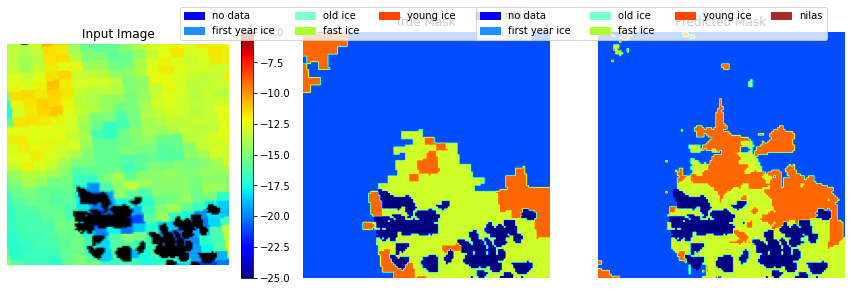

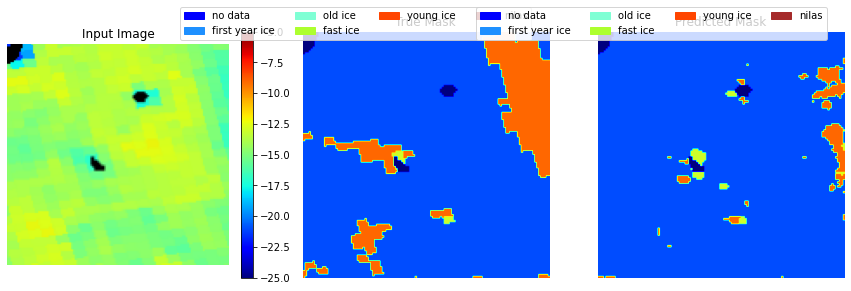

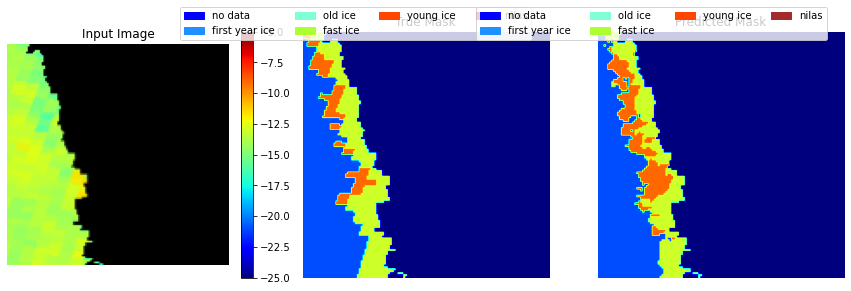

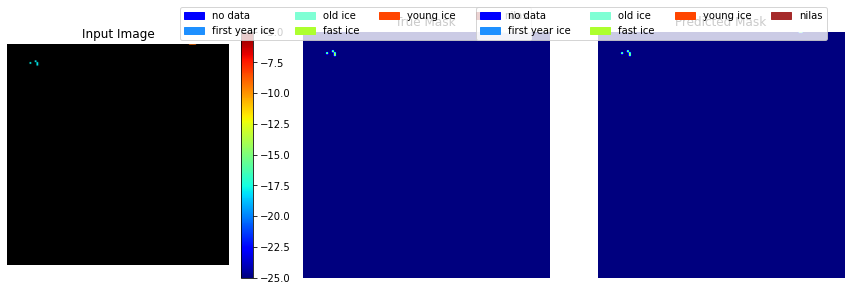

In [39]:
show_predictions(test_dataset, 20)  